# Conditioning and Bayes
### Understanding Uncertainty

## Introduction
- Maximum Likelihood (plus confidence intervals, hypothesis tests, $p$-values, standard errors, sampling distribution) are the framework of **frequentist statistics**: We run experiments many times, and it reveals the reliability of our procedures
- In frequentist statistics, we use those experiments to learn about a true, fixed $\beta$ by way of estimates $\hat{\beta}_n$
- In Bayesian statistics, $\beta$ is assumed to be a random variable about which we hold explicit beliefs (a distribution): We use data as evidence to update those beliefs
- Like with bootstrapping, the "answer" in Bayesian statistics is a "posterior distribution" after witnessing the data: The answer is typically a distribution, not a number

## Roadmap
1. Conditional Probability
2. A Glimpse of Bayesian Statistics

## Motivating Example: Confusion Matrices and Classification Metrics
- Let's use the metabric data to predict who is classified as alive or dead by the end of the sample period

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/metabric.csv')
df.head()

,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Chemotherapy,Hormone Therapy,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Overall Survival Status,Radio Therapy,TMB (nonsynonymous),Tumor Size,Tumor Stage
0,43.19,BREAST CONSERVING,Breast Cancer,NO,YES,0.0,2.0,4.020,84.633333,0:LIVING,YES,2.615035,10.0,1.0
1,48.87,MASTECTOMY,Breast Cancer,YES,YES,1.0,2.0,4.030,163.700000,1:DECEASED,NO,2.615035,15.0,2.0
2,47.68,MASTECTOMY,Breast Cancer,YES,YES,3.0,1.0,4.050,164.933333,0:LIVING,YES,1.307518,25.0,2.0
3,76.97,MASTECTOMY,Breast Cancer,YES,YES,8.0,2.0,6.080,41.366667,1:DECEASED,YES,2.615035,40.0,2.0
4,78.77,MASTECTOMY,Breast Cancer,NO,YES,0.0,4.0,4.062,7.800000,1:DECEASED,YES,5.230071,31.0,4.0


Tumor Size
20.0    173
25.0    123
15.0    117
30.0    113
18.0     54
       ... 
7.0       1
41.0      1
6.0       1
2.0       1
75.0      1
Name: count, Length: 70, dtype: int64


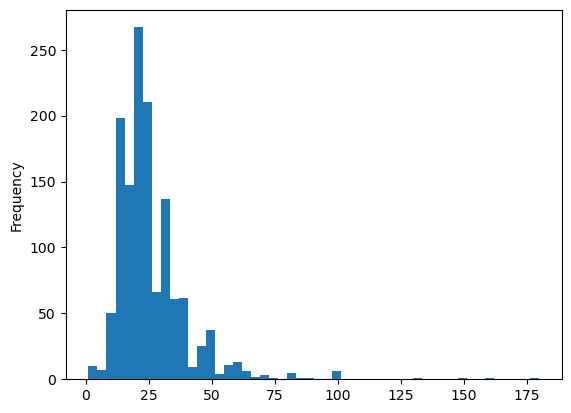

<Axes: ylabel='Frequency'>

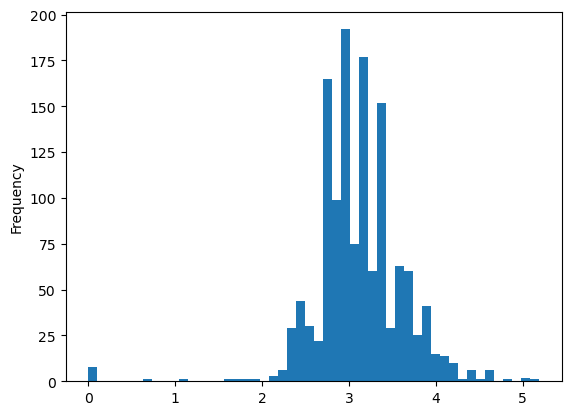

In [47]:
print(df['Tumor Size'].value_counts())
df['Tumor Size'].plot.hist(bins=50)
plt.show()

df['size_log'] = np.log(df['Tumor Size'])
df['size_log'].plot.hist(bins=50)

Mutation Count
4.0     188
5.0     183
3.0     165
6.0     163
2.0     156
7.0     107
1.0      93
8.0      90
9.0      62
10.0     43
11.0     25
12.0     17
13.0     14
14.0      8
15.0      5
16.0      4
17.0      3
22.0      3
19.0      2
23.0      2
20.0      2
18.0      2
21.0      1
26.0      1
41.0      1
24.0      1
30.0      1
46.0      1
Name: count, dtype: int64


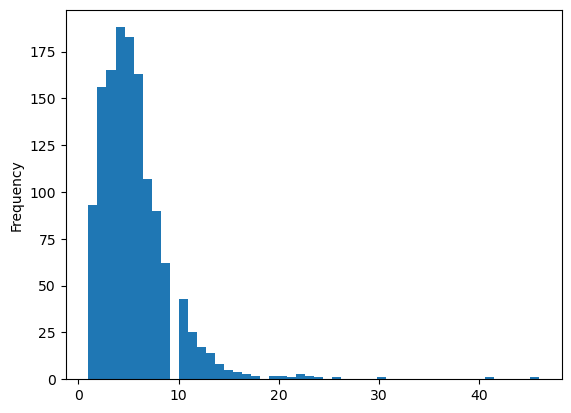

<Axes: ylabel='Frequency'>

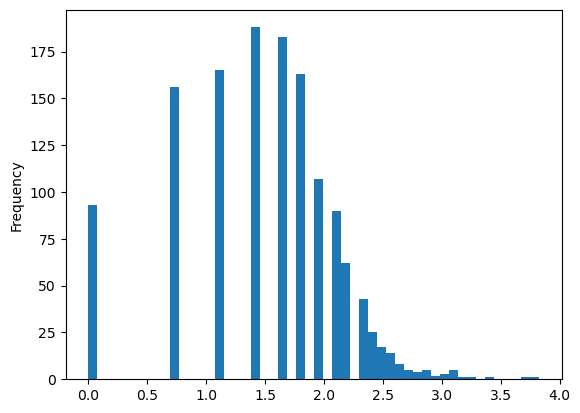

In [48]:
print(df['Mutation Count'].value_counts())
df['Mutation Count'].plot.hist(bins=50)
plt.show()

df['mut_log'] = np.log(df['Mutation Count'])
df['mut_log'].plot.hist(bins=50)

In [49]:
# Clean Data:
vars_num = df.loc[:, ['Age at Diagnosis', 
                     'Nottingham prognostic index', 
                     'TMB (nonsynonymous)',
                     'size_log',
                     'mut_log'] ]

stage = pd.get_dummies(df['Tumor Stage'], drop_first=True, dtype=int)
radio = pd.get_dummies(df['Radio Therapy'], drop_first=True, dtype=int)
chemo = pd.get_dummies(df['Chemotherapy'], drop_first=True, dtype=int)
type = pd.get_dummies(df['Type of Breast Surgery'], drop_first=True, dtype=int)

y = df['Overall Survival Status'].copy().replace({'1:DECEASED':'0','0:LIVING':'1'})
y = pd.to_numeric(y,errors='coerce')

In [ ]:
## Organize data:
data = pd.concat([y, vars_num, stage, radio, chemo, type], axis=1)
print(data.shape)
data.dropna()
print(data.shape)

y = data['Overall Survival Status']
X = data.drop('Overall Survival Status',axis=1)
X = np.array(X)

## Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

(1343, 13)
(1343, 13)


In [51]:
## Fit a predictive model:
reg = MLPClassifier(solver = 'adam',
                        hidden_layer_sizes=(64), #, 32),
                        activation='logistic',
                        max_iter = 2000)
reg = reg.fit(X_train,y_train)
y_hat = reg.predict(X_test)
print( 'Test Accuracy: ', reg.score(X_test,y_test) ) ## Accuracy

Test Accuracy:  0.6654275092936803


In [52]:
## Confusion matrix:
tab = pd.crosstab(y_test,y_hat)
tab

col_0,0,1
Overall Survival Status,,
0,117,32
1,58,62


## 

## Confusion Matrix
- So, not a great model, but it tries. Out of 269 cases, 
    - 118 were correctly predicted as negative: **True Negatives (TN)**
    - 62 were correctly predicted as positive: **True Positive (TP)**
    - 58 were positive, but predicted negative: **False Negatives (FN)**
    - 31 were negative, but predicted positive: **False Positive (FP)**
- We wish to make sense of these numbers, but there are many definitions on which to analyze them
- Do we care about the asymmetry between FP and FN?

## Accuracy
- Out of the total population, how many did we get right? This is called **accuracy**:
$$
\text{Accuracy} = \frac{TP+TN}{N}
$$
- In this case, we get .699. Despite making a significant number of errors, about 70% of our predictions are correct.
- In our frequentism world, we could get the sampling distribution. This is an estimate.
- This estimates, **What is the probability this model makes a correct prediction?**
- But this suggests a probabilistic interpretation of the table, as an estimator

## The Joint Density/Mass Function
- If we divide the table by $N$, we get a **joint distribution**
- Each cell says, "If someone walks in the door, what are we likely to predict for them and are they likely to live or die?"

In [53]:
N_test = len(y_test)
joint = tab/N_test
joint

col_0,0,1
Overall Survival Status,,
0,0.434944,0.118959
1,0.215613,0.230483


- So we have two random variables: The truth and our prediction. They have some stochastic relationship, summarized by the numbers in the table.

## Marginal Distributions
- If we sum over one of the variables, holding the other constant, we get a valid distribution function, called the **marginal distribution**

In [54]:
np.sum(joint,axis=0) # Marginal of predicted

col_0
0    0.650558
1    0.349442
dtype: float64

In [55]:
np.sum(joint,axis=1) # Marginal of true

Overall Survival Status
0    0.553903
1    0.446097
dtype: float64

- 55% actually die, 44% actually live.

## Marginal Distributions
- We "integrate out" one of the variables to see how the other behaves on its own terms:
$$
f_Y(y) = \begin{cases}
\sum_{x} f_{XY}(x,y), & \text{ $X$ is discrete}\\
\int_{x} f_{XY}(x,y)dy, & \text{ $Y$ is continuous}
\end{cases}
$$
- We're removing one of the variables from the situation to focus on the other

## Conditional Distributions
- What if we've seen the prediction... Now, is it accurate?
- So imagine you've been told the test is positive. Are you *certain* you're going to die? Of course not. 
- What is the actual performance of the signal, on the test set?

## Conditional Distributions
- So, if I see a 0 prediction, I know it's only correct with probability
$$
\text{Negative Predictive Value} = \dfrac{TP}{TP+FP} 
$$
and if I see a 1 prediction, I know it's only correct with probability
$$
\text{Positive Predictive Value} = \dfrac{TN}{TN+FN}
$$
- So, holding the column fixed, I compute the mass of each cell divided by total mass of the column
$$
\mathbb{P}[0|\hat{0}] = \frac{\mathbb{P}[0,\hat{0}]}{\mathbb{P}[\hat{0}]}, \quad \mathbb{P}[1|\hat{1}] = \frac{\mathbb{P}[1,\hat{1}]}{\mathbb{P}[\hat{1}]}
$$
- These are hardly certain, despite the binary nature of the prediction

In [56]:
tab = np.array(tab)
tab

array([[117,  32],
       [ 58,  62]])

In [57]:
conditional_y_hat = tab/np.sum(tab,axis=1,keepdims=True)
conditional_y_hat

array([[0.7852349 , 0.2147651 ],
       [0.48333333, 0.51666667]])

## Conditional Distributions
- Likewise, we can ask, "What if someone is NOT going to die? Does the model predict that?" Then we want to compute
$$
\text{Sensitivity} = \dfrac{TP}{TP+FN} = \dfrac{62}{62+58}
$$
- Conversely, "What if someone is going to die? Does the model predict it correctly?"
$$
\text{Specificity} = \dfrac{TN}{TN+FP} = \dfrac{118}{118+31}
$$
- So, holding the row fixed, I compute the mass of each cell divided by total mass of the row
$$
\mathbb{P}[\hat{1}|1] = \frac{\mathbb{P}[1,\hat{1}]}{\mathbb{P}[1]}, \quad \mathbb{P}[\hat{0}|0] = \frac{\mathbb{P}[0,\hat{0}]}{\mathbb{P}[0]}
$$


In [58]:
tab

array([[117,  32],
       [ 58,  62]])

In [59]:
joint

col_0,0,1
Overall Survival Status,,
0,0.434944,0.118959
1,0.215613,0.230483


In [60]:
conditional_y = tab/np.sum(tab,axis=1,keepdims=True)
conditional_y

array([[0.7852349 , 0.2147651 ],
       [0.48333333, 0.51666667]])

## Who cares?
- This is arguabl
- If you are a patient, anxious about the likelihood you actually live or die. Which do you want to know: Sensitivity/Specificity, or NPV/PPV?
- If you are a doctor, deciding how to treat the patient. Which do you want to know: Sensitivity/Specificity, or NPV/PPV?

## Conditional Distributions
- Now, re-normalize the joint probabilities by the conditioning event that $X=x$:
$$
f[y|X=x] = \begin{cases}
\frac{f_{XY}(x,y)}{\sum_{\{x:X=x\}} f_{XY}(x,y)}, & \text{ $X$ is discrete}\\
\frac{f(x,y)}{f_X(x)}, & \text{ $X$ is continuous}
\end{cases}
$$
- We're holding one variable constant, and seeing how the density/mass of the other changes

## Key Analytical Insight
- If we have a multivariate context, we can **condition** on one variable to understand the other
- We can always write
$$
\underbrace{\mathbb{P}[A \cap B]}_{\text{Joint}} = \underbrace{\mathbb{P}[A|B]}_{\text{Conditional}} \times \underbrace{\mathbb{P}[B]}_{\text{Marginal}}
$$
$$
\underbrace{f_{YX}(y,x)}_{\text{Joint}} = \underbrace{ f_{Y|X}[y|x] }_{\text{Conditional}} \times \underbrace{f_X(x)}_{\text{Marginal}}
$$
- So, hold $B$ or $X=x$ constant and analyze $A$ or $Y$, then adjust $X=x$ to cover the range of possible values for $X$


## Conditional Probability: Events
- To understand conditional probability, let's dump the notation, then do examples: For two events $A$ and $B$, the probability of $A$ given that $B$ has occurred is
$$
\mathbb{P}[A|B] = \dfrac{\mathbb{P}[A \cap B]}{\mathbb{P}[B]}
$$
- So the **probability of event $A$ given event $B$** is the probability of the intersection... normalized by the probability of $B$
- We did this all the time at the beginning of class, with non-parametric estimation: "Given we're in this bin/neighborhood, how many data points are there? How many satisfy our condition of interest?" 

## Conditional Probability: Densities
- In the case that we have a random variable $Y: Z|X \rightarrow \mathbb{R}$, we have
$$
f[y|X=x] = \frac{f_{XY}(x,y)}{f_X(x)}
$$
- Notice that the denominator is a density, not a distribution or mass function

## Wrapping Up
- Just because you predict it, doesn't make it true
- We can have uncertainty about parameters, not just the model

# Bayesian Statistics and Modeling

## Bayesian Inference
- In frequentism -- exemplified by MLE -- parameters like $\mu$ and $\lambda$ are fixed, and we reason about their probable values by looking at data
- In Bayesianism, we model the parameters like $\mu$ and $\lambda$ as explicitly random, with distributions called a **prior distribution**, that we typically select based on our subjective experience
- We then use data to update our priors, yielding a **posterior distribution** that expresses our beliefs about the likely value of the parameters after seeing the data
- I cannot possibly get through much of Bayesian reasoning: We want to focus on the basic ideas, and then you can read BDA3 or something comparable to get the tools

## Set-up
- So we have a situation. $X$ are the random data, and $\beta$ are the random coefficients.

    - We have a prior density $f_\beta(\beta)$ about the likely values of $\beta$
    - We have a likelihood $L(x,\beta) = f[x|\beta]$ that maps our parameters into the joint density of observing the data
    - We have the marginal $f_X(x) = \int_{\beta'} f[x|\beta']f_{\beta}(\beta') d\beta'$

- It turns out that we can write the posterior, $f[\beta|X=x]$ in terms of the above quantities (which are all known and observable from data), which is Bayes' Rule

## Bayes' Rule
- Recall the conditional density is given by
$$
f[\beta|X=x] = \dfrac{f(\beta,x)}{f_X(x)},
$$
and similarly, $f(\beta,x) = L(x,\beta)f_\beta(\beta)$.
- Then **Bayes' Rule** is
$$
f[\beta|X=x] = \dfrac{L(x,\beta)f_\beta(\beta)}{f_X(x)}
$$
- Notice we used the defintion of conditional probability **twice**. Once to get that ratio, and once to convert the joint into the reverse conditional probability.
- In words, "the posterior is the likelihood times the prior, divided by the marginal"

## Operationalizing Bayes' Rule
- Let's rewrite that, with more parts labeled:
$$
\underbrace{f[\beta|X=x]}_{\text{Posterior}} = \dfrac{ \underbrace{L(x,\beta)}_{\text{Likelihood}} \quad \times \quad \underbrace{f_\beta(\beta)}_{\text{Prior}}}{\underbrace{f_X(x)}_{\text{Marginal}}}
$$
- So instead of the frequentist/bootstrap framework of examining the sampling distribution of a statistic, we do the thing you probably think is obvious: Look at data and update our beliefs about parameters 
- Notice how central the role of the likelihood still is: We're combining our frequentist approach with an additional piece, the prior over the parameters $\theta$. Previously, we treated them as fixed features of reality and tried to calibrate them in our models to match observed outcomes.
- What is the denominator? Just the marginal probability of observing the data, and it equals $f_X(x) = \int_{\beta'} L(x,\theta') \pi(\theta')d\theta'$

## Bayesian Modeling
- It is not that different from MLE, in many ways:

    0. Pick a likelihood that is appropriate for generating your data, the same as we did for MLE. Pick a prior and its parameters to express your subjective beliefs about the likely values of the likelihood.
    1. Use Bayesian updating to transform your prior $\pi(\theta)$ into your posterior $p[\theta|X=x]$
    2. Use your posterior to conduct analyses (most likely $\theta$, prediction intervals, plug-in estimates for decision models, etc.) 

- Step 1 is not typically handled analytically by formulas these days, except for some special cases. It is done computationally, using Stan or PyMC.
- Under the hood, Bayesian inference is a computationally heavy field: We typically don't explicitly update the prior using formulas, we ask the computer to provide a sample of parameter draws from the posterior distribution (this is very similar to bootstrapping and the sampling distribution)

## Analytical Example: Bernoulli Likelihood with a Beta Prior
- This is the classic introductory example
- The data are $\{0,1\}$-valued draws from a Bernoulli distribution: $pr[y] = p^{y}(1-p)^{1-y}$ for $y \in \{0, 1\}$
- $0 \le p \le 1$ is now random: We don't know what it is, but we have a prior that it is distributed Beta, with "known" parameters $(\alpha, \beta)$:
$$
\pi(p) = c p^{\alpha-1} (1-p)^{\beta-1}
$$
where $c$ is a constant what won't matter for our problem
- When we multiply the prior times the likelihood, we get the posterior that
$$
\underbrace{f[p|y]}_{\text{posterior}} = \dfrac{c p^{\alpha+\sum_i y_i -1 } (1-p)^{\beta + n - k -1}}{pr[y]}
$$
- Staring at this implies the posterior must be a Beta distribution with parameters $\alpha' = \alpha+k$ and $\beta' = \beta + n-k$
- That's it!
- Many edge cases are possible, if you pick the prior and likelihood to have shapes that return the same functional form as the prior; many textbooks on Bayesian analysis are full of chapters of this kind of thing

## PyMC
- There are great options for Bayesian statistics and modeling: Stan and PyMC are popular and very high quality
- We want to avoid the "distribution/density games" around Bayesian modeling: Pick a natural likelihood and an appropriate prior and go estimate computationally, rather than try to game out a perfect conjugacy relationship that gives you a cute posterior and closed-form solution

## Example: Housing Prices
- Let's predict (log-)house prices from house characteristics 
- The 00_bayes_pymc.py file in the repo has the results, and gives the flavor of a Bayesian analysis
- Our basic model is $\ln(p_i) = \beta_0 + \beta_1 \text{age} + \sigma \varepsilon_i$
- Our basic prior is that $\beta_0$ and $\beta_1$ are normally distributed with means of 0 and standard deviations of 10, and $\sigma$ is "half-normal" with a standard deviation of 1
- Roughly: Instead of a sampling distribution, we have a posterior distribution; the point estimates are similar and therefore point predictions will be similar

## The Hardest Part to Understand
- Computational Bayesian methods do not typically solve or optimize
- Computational Bayesian methods instead try to sample from the posterior distribution, and give you a sample of draws to play with
- You then do... non-parametric statistics (KDE/ECDF/LCLS) on the sample
- So, if you thought the beginning of the class was a digression, I sympathize, but it's KDE/ECDF all the way down
- The sample is drawn using Markov Chain Monte Carlo, a sophisticated method for generating samples from data-driven distributions

## MLE vs Bayesian
- The intuition is, the posterior density and the sampling distribution are similar objects, and we use them in similar ways, but with very different interpretations
- As the sample size grows, the Bayesian updating step will place more and more weight on the likelihood than the prior
- This means that the Bayesian estimates converge to the MLE ones in large samples (this is called the Bernstein-von Mises theorem: The Bayesian posterior converges to the CLT-based frequentist limit) 
- Like most holy wars in academia, the differences between frequentist and Bayesian are slight, once you master both frameworks; it's mostly people who don't fully understand one or the other making all the noise about intellectual purity

## Bayesian Advantages with Big Data
- When the sample size is small, but our prior is strong
- Hierarchical modeling, in which the data involve "different layers of resolution" (e.g. students/classes/schools/school districts, patients/doctors/wards/hospitals/HMOs, defendants/judges/counties/states)
- The posterior need not be fully parametric, and can go right into decision support systems (Bayesian optimization)
- Empirical Bayes: Use the Bayesian framework, but then estimate the parameters of the prior as if you're doing MLE, and don't worry about the philosophical contradictions.

## Conclusion
- So, we're done!
- You have seen non-parametric statistics, frequentist statistics and bootstrapping, and Bayesian statistics, alongside a basic grounding in theoretical probability (probability space, random variable, density, distribution, expectation)
- There is always more to know, but remember: You can always just bootstrap